<font size = 6>Evaluating the Longstaff-Schwartz Method for Pricing of American Options - Exercise Boundaries and Future Work</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Oct 28, 2022</div></font>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import norm
from numpy.polynomial.laguerre import lagval
from numpy.linalg import pinv
from sklearn.isotonic import IsotonicRegression as Isotonic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Export path & Format
path = "D:\\Work\\"
path_format_P = ("Put_" + "%s" + "_S_" + "%s" + "_D_" + "%s" + "_N_" + "%s" + ".csv")
path_format_C = ("Call_" + "%s" + "_S_" + "%s" + "_D_" + "%s" + "_N_" + "%s" + ".csv") 

In [2]:
# Return Lagguerre Polynomial values(given degree)
def L(x_vec, degree, weighted = False):
    L = []
    for x in x_vec:
        L_temp = [1]
        for i in range(1, degree + 1):
            L_temp.append(lagval(x, [1] * (i+1)) - np.sum(L_temp))
        if not weighted:
            L.append(L_temp)
        else:
            L.append((np.array(L_temp) * np.exp(-x / 2)).tolist())  
    return np.array(L)

<font face="Times Roman" size=4>
    $\qquad$In this report, I will only use the Brownian bridge (conditional distribition of preceding elements) to simulate the paths backward from expiry (2.2 in Gustafsson's report) instead of the naive method which requires much more memory (2.1 in Gustafsson's report). And I am going to use Longstaff-Schwartz method to find the continuation values and exercise boundaries for American call and put options. <br>
</font>

# Exercise Boundaries

<font face="Times Roman" size=4>
    In this part, I am going to plot the exercise boundaries for call and put options and have some discussion on the call options. 
</font>

In [58]:
def longstaff_schwartz_c(S0, degree, N, path = path, nreps = 20, npaths = int(1e4), export_temp_matrices = False, weighted = False):
    # degree - Laguerre basis degree
    # N - Number of time steps
    # path - export path
    # nreps - replication times
    # npaths - number of generated paths
    S = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    P = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    tstar = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    Sstar = pd.DataFrame(columns =[pointer(i, j) for i in np.arange(1,nreps + 1,1) for j in np.arange(1,N + 1,1)])
    
    exec_time = pd.DataFrame(index = [0], columns =[i for i in np.arange(1,nreps + 1,1)])
    lsm_price = pd.DataFrame(index = [0], columns =[i for i in np.arange(1,nreps + 1,1)])
    t = np.arange(0, 1 + 1 / N, 1 / N)[:N+1] 
    
    for i in np.arange(1,nreps + 1,1):
        # The current number of repitition
        init_time = datetime.now()
        # Antithetical sampling
        z = (t[-1] - t[0]) * np.random.randn(int(np.ceil(npaths / 2)))
        # W - value at expiry
        W = (r - 0.5 * sigma**2) * (t[-1] - t[0]) + sigma * np.append(z, -z)
        # Spot prices at expiry (a log-normal distribution)
        S[pointer(i, N)] = S0 * np.exp(W)
        # Discounted final payouts
        P[pointer(i, N)] = S[pointer(i, N)].apply(g_c)

        # Store information about early exercise
        # Exercise time for put
        tstar[pointer(i, N)] = [t[-1]] * npaths
        # Exercise price for put
        Sstar[pointer(i, N)] = S[pointer(i, N)]

        for j in range(N - 1, 0, -1):
            # The current index of time
            #  Sample for the preceding element in the bridge
            dt = t[j + 1] - t[j]
            #  Antithetical sampling of final prices:
            z = np.random.randn(int(np.ceil(npaths / 2)))
            z = np.append(z, -z)

            # Use Conclusions in Brownian Bridge to Sample the preceding element
            W = W * (t[j] / t[j+1]) + sigma * np.sqrt(dt * (t[j] / t[j+1])) * z
            S[pointer(i, j)] = S0 * np.exp(W)
            P[pointer(i, j)] = np.exp(-dt * r) * P[pointer(i, j+1)]  # Continue holding unless...
            citm = S[pointer(i, j)].apply(g_c) > 0 # Put in the money

            if citm.sum() > 0:
                x = S[pointer(i, j)][citm]  # Spot prices of each realization   
                y = P[pointer(i, j)][citm]  # Continuation value of each realization
                ind = citm[citm == True].index

                # Regression Coefficients: Laguerre basis
                design = L(x, degree = degree, weighted = weighted)
                # Regression
                # centered on zero (as per Gustaffson)
                betahat = np.dot(pinv(design), y - 0)
                # Regression value
                Chat = 0 + np.dot(design, betahat)

                # Execute early exericse
                early = ind[x.apply(g_c) > Chat]
                tstar.loc[early, pointer(i, j)] = t[j]
                Sstar.loc[early, pointer(i, j)] = S[pointer(i, j)][early]
                P.loc[early, pointer(i, j)] = S[pointer(i, j)][early].apply(g_c)

        exec_time.loc[0, i] = (datetime.now() - init_time).total_seconds()
        lsm_price.loc[0, i] = np.exp(t[0] - t[1]) * P[pointer(i, j)].mean()
    
    exec_time.to_csv(path + path_format_C % ("exec_time", str(S0), str(degree), str(N)))
    lsm_price.to_csv(path + path_format_C % ("lsm_price", str(S0), str(degree), str(N)))
    if export_temp_matrices:
        S.to_csv(path + path_format_C % ("S", str(S0), str(degree), str(N)))
        P.to_csv(path + path_format_C % ("P", str(S0), str(degree), str(N)))
        Sstar.to_csv(path + path_format_C % ("Sstar", str(S0), str(degree), str(N)))
        tstar.to_csv(path + path_format_C % ("tstar", str(S0), str(degree), str(N)))

In [20]:
longstaff_schwartz_c(S0 = 90, degree = 4, N = 100, export_temp_matrices = True)
longstaff_schwartz_c(S0 = 100, degree = 4, N = 100, export_temp_matrices = True)
longstaff_schwartz_c(S0 = 110, degree = 4, N = 100, export_temp_matrices = True)

<font face="Times Roman" size=4>
    Let us first have a look at the accuracy of call opiton pricing using Longstaff-Schwartz method. 
</font>

In [50]:
def read_lsmc_price(N, degree = 4, nreps = 20, path = path, path_format_C = path_format_C):
    Lsm_price = pd.DataFrame([], columns = [i for i in range(1, nreps+1)], index = [90, 100, 110])
    for S in [90, 100, 110]:
        Lsm_price.loc[S, :] = pd.read_csv(path + path_format_C % ("lsm_price" ,str(S), str(degree), str(N)), index_col = 0).values
    return Lsm_price

In [51]:
Lsmc_price = read_lsmc_price(100)

In [52]:
# For example (x-axis represents index of replication, y-axis represents initial stock prices)
Lsmc_price

1          2         3          4         5          6   \
90    2.554622   2.758226   2.67643   2.744739  2.663774   2.717965   
100   7.394479   7.421231  7.514402   7.313816  7.318172   7.176712   
110  14.600228  14.538757  14.46205  14.681731  14.56765  14.548372   

            7          8          9          10         11        12  \
90    2.716098    2.75756   2.752856   2.681527   2.630361  2.714231   
100   7.428718   7.432014    7.25572   7.197481   7.303259  7.469547   
110  14.584892  14.659305  14.535422  14.568995  14.608281  14.62412   

            13        14         15         16         17        18  \
90    2.725756  2.606495   2.651849   2.822659   2.770465  2.780296   
100   7.501181   7.32306   7.354565   7.554341    7.37877  7.462057   
110  14.599141  14.54133  14.567655  14.613299  14.553525  14.48969   

            19         20  
90    2.637675   2.732805  
100   7.358954   7.317903  
110  14.556085  14.552984

<font face="Times Roman" size=4>
    Here are the results computed using PDE method, where the second one has more dense grid and is more accurate. (In Appendix) 
</font>

In [5]:
BS4.PDE_price((N_space1, N_time1))
BS4.PDE_price((N_space2, N_time2))

In [5]:
BS5.PDE_price((N_space1, N_time1))
BS5.PDE_price((N_space2, N_time2))

In [6]:
BS6.PDE_price((N_space1, N_time1))
BS6.PDE_price((N_space2, N_time2))

<font face="Times Roman" size=4>
    And here are the results computed using Black-Scholes formula, which are the estimations of European option prices (As well as the American option prices).
</font>

In [54]:
bs_c(90)
bs_c(100)
bs_c(110)

2.7584438561460694

7.485087593912603

14.702019669720784

<font face="Times Roman" size=4>
    Finally, take the mean of the results above and get the estimations using Longstaff-Schwartz method.
</font>

In [53]:
# Longstaff-Schwartz results
Lsmc_price.mean(axis = 1)

90      2.704820
100     7.373819
110    14.572676
dtype: float64

<font face="Times Roman" size=4>
    We can see that, for call options, the Longstaff-Schwartz method has a much larger bias compared to put option in all the cases including in-the-money, at-the-money and out-of-money. Besides, this method also tends to underestimate the prices like put option cases.<br>
    <br>
    Finally, let us have a look at the exercise boundaries for call and put options.
</font>

In [24]:
def read_tstar_Star(flag, N = 100, degree = 4, nreps = 20, path = path, path_format_P = path_format_P, path_format_C = path_format_C):
    if flag == "p":
        path_format = path_format_P
    else:
        path_format = path_format_C
    tSstar = {S: {} for S in [90, 100, 110]}
    for S in tSstar.keys():
        tstar = pd.read_csv(path + path_format % ("tstar" ,str(S), str(degree), str(N)), index_col = 0).mean(axis=0)
        tstar = pd.DataFrame(tstar.values.reshape(20, 100)).mean(axis = 0)
        Sstar = pd.read_csv(path + path_format % ("Sstar" ,str(S), str(degree), str(N)), index_col = 0)
        Sstar = pd.DataFrame(Sstar.values.reshape(200000, 100))
        tSstar[S] = (tstar, Sstar)
    return tSstar

In [25]:
tSstar_p = read_tstar_Star("p")
tSstar_c = read_tstar_Star("c")

In [68]:
def plot_exercise_boundary(flag, tSstar):
    fig = plt.figure(figsize=(20, 6))
    for i, S in enumerate([90, 100, 110]):
        tstar = tSstar[S][0]
        Sstar = tSstar[S][1]
        ax = fig.add_subplot(1, 3, i + 1)
        sorted_Sstar = pd.DataFrame([], columns = Sstar.columns, index = Sstar.index)
        for i in range(Sstar.shape[1]):
            sorted_Sstar.iloc[:, i] = Sstar.iloc[:, i].sort_values(ignore_index = True).values
        upper_std_vec = []
        lower_std_vec = []
        mean_vec = []
        for i in range(tstar.shape[0]):
            if not np.isnan(tstar[i]):
                temp = sorted_Sstar.iloc[:, i].dropna().values
                temp_range = temp[-1] - temp[0]
                mean_vec.append(temp.mean())
                upper_std_vec.append(temp.mean() + temp.std())
                lower_std_vec.append(temp.mean() - temp.std())
                if i == tstar.shape[0] - 1:
                    ax.scatter([tstar[i]] * temp.shape[0], temp, s = 1, c = 'k', alpha = 0.8, label = "exercised samples (color represents density)")
                else:
                    ax.scatter([tstar[i]] * temp.shape[0], temp, s = 0.5, c = 'k', alpha = 0.08)
        ax.plot([0, 1], [S, S], label = "initial value of stock", c = "g", ls = '--', lw = 1)
        ax.plot([0, 1], [100, 100], label = "strike price of stock", c = "orange", ls = '--', lw = 1)
        ax.plot(tstar.dropna().values[:-1], mean_vec[:-1], label = "sample mean of exercised samples")
        ax.plot(tstar.dropna().values[:-1], lower_std_vec[:-1], lw = 2, ls = '--', c = 'r', alpha = 0.8)
        ax.plot(tstar.dropna().values[:-1], upper_std_vec[:-1], lw = 2, ls = '--', c = 'r', alpha = 0.8, label = "one standard deviation confidence interval")
        ax.set_xlim(0, 1)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Time", fontsize=14)
        if flag == "c":
            ax.legend(fontsize=10)
            ax.set_title("Call Option Exercise Boundary for S0 = %s" % str(S), fontsize = 14)
        else:
            ax.legend(fontsize=12)      
            ax.set_title("Put Option Exercise Boundary for S0 = %s" % str(S), fontsize = 14)
        if S == 90:
            plt.ylabel("Prices", fontsize=14)

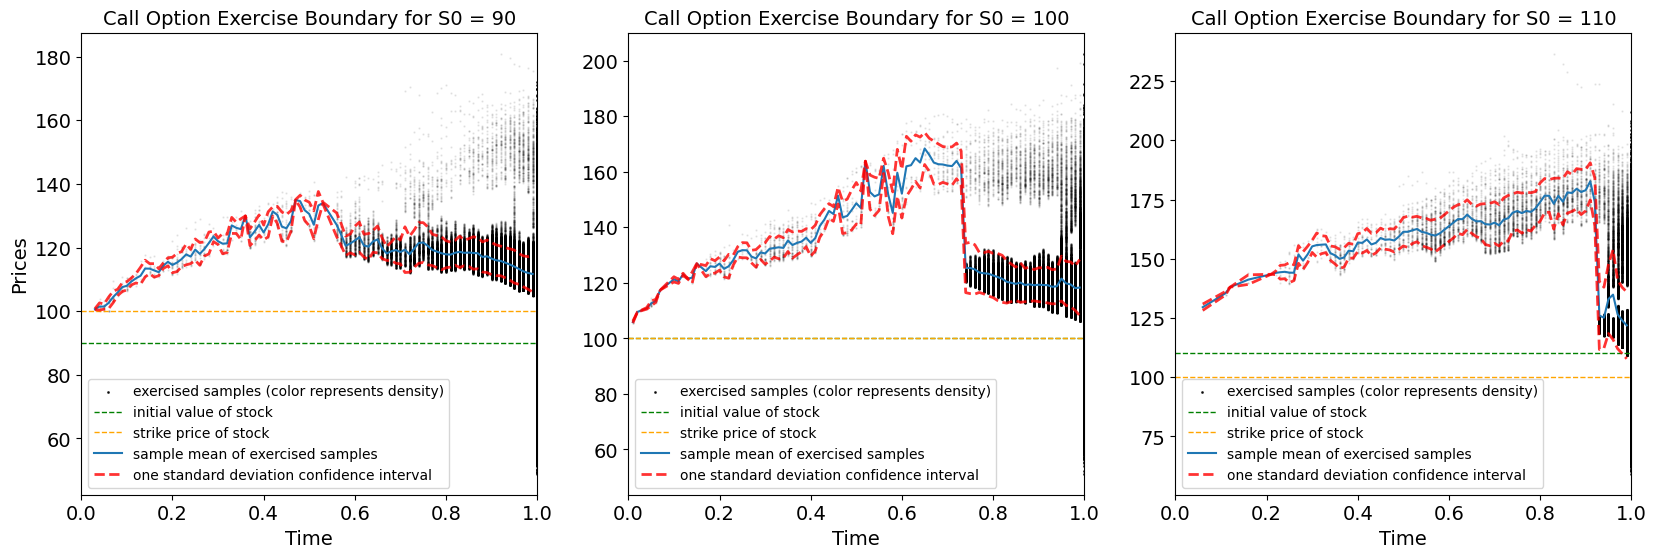

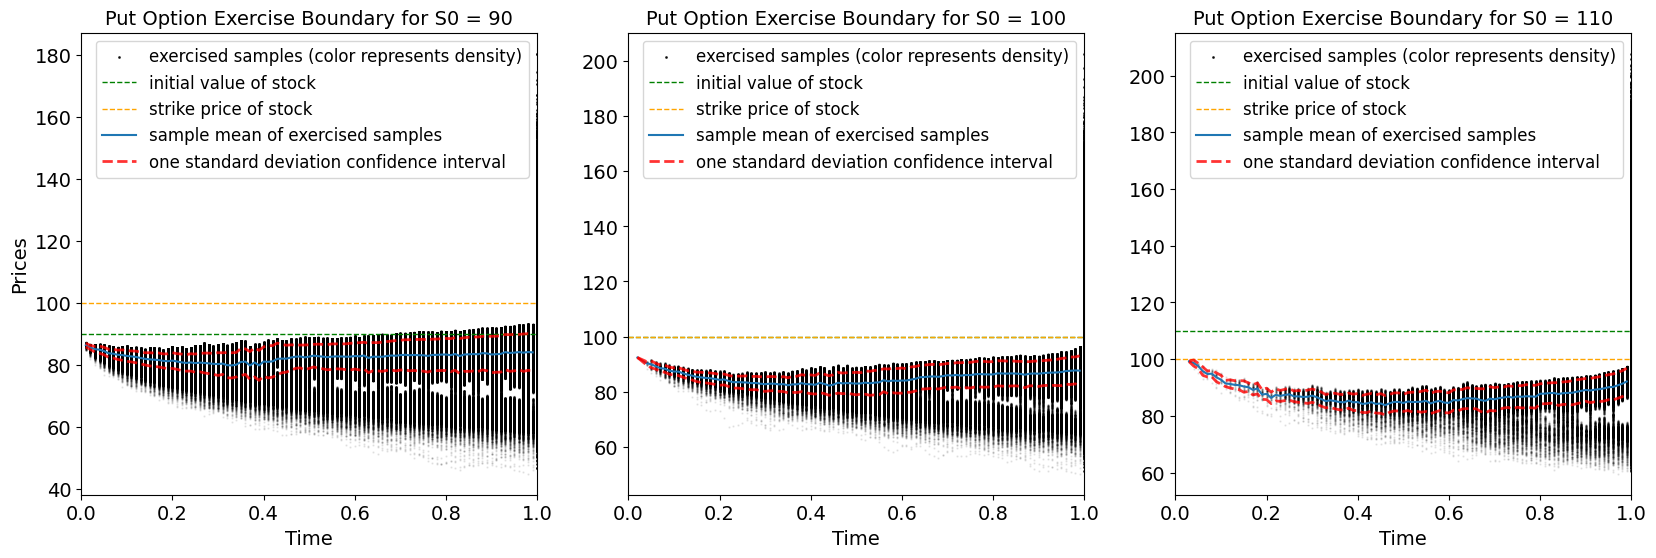

In [69]:
plot_exercise_boundary("c", tSstar_c)
plot_exercise_boundary("p", tSstar_p)

<font face="Times Roman" size=4>
    $\qquad$Firstly, we can see that, for both cases, there are much fewer exercised samples that are deep in the money than others. In other words, exercised samples clustered in somewhere not far away from the strike prices.<br>
    $\qquad$And we can see that it seems that the put options are more stable and have lower variances that call options, which tells us Longstaff-Schwartz method is more effective in pricing put options.<br>
    $\qquad$In the case of call options, though we can see that there is a abrupt decreasing closed to the end and thus is not so reliable. But maybe we could get a smoother curve by simulating more paths. And this is very intuitive, as time goes by, for those who have American call options which are sightly higher than strike price tend to early exercise. And at very beginning, if there is a very high intrinsic value, people tend to exercise instead of following the textbook and holding them. <br>
    $\qquad$Thus I think maybe Longstaff-Schwartz method is not that bad at pricing American call option.
</font>

# Further work

<font face="Times Roman" size=4>
    Of course there are a lot of things to be done in the future. This report just simply analyze how to compute the American options using Monte Carlo method, which is very good at finding their exercise boundaries, but is likely to suffer from low speed and large memory cost.<br>
    <br>
    Here are some interesting topics:
    <ul>
    <li>What would happen if we use different function polynomials like Hermite, Legendre, Chebyshev, Gegenbauer, and Jacobi polynomial. </li>
    <br>
    <li>What would happen if we use weighted Laguerre polynomials where the author said that it was more inaccurate</li>
    <br>
    <li>Would the results converge if we use more time steps.</li>
    <br>
    <li>Would the results converge if we use more degrees of polynomial.</li>
    <br>
    <li>How good the regression step works (What professor has done in the class).</li> 
    </ul>
</font>

In [ ]:
#longstaff_schwartz_c(S0 = 90, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_c(S0 = 100, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_c(S0 = 110, degree = 4, N = 100, export_temp_matrices = True, weighted = True)

In [ ]:
#longstaff_schwartz_p(S0 = 90, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_p(S0 = 100, degree = 4, N = 100, export_temp_matrices = True, weighted = True)
#longstaff_schwartz_p(S0 = 110, degree = 4, N = 100, export_temp_matrices = True, weighted = True)

In [ ]:
# Other Choice (Non-equally spaced times)
# npaths = int(10000)
# timestep = 0.002
# t = np.arange(0, 1 + timestep, timestep)**(1/5)

# mono = 0  
# mono - use monotone regression instead of polynomial least squares


for k in range(N-1, 0, -1):   
    #  Sample for the preceding element in the bridge
    dt = t[k+1] - t[k]
    #  Antithetical sampling of final prices:
    z = np.random.randn(int(np.ceil(npaths / 2)))
    z = np.append(z, -z)

    # Use Conclusions in Brownian Bridge to Sample the preceding element
    W = W * (t[k] / t[k+1]) + sigma * np.sqrt(dt * (t[k] / t[k+1])) * z
    S = S0 * np.exp(W)
    P = np.exp(-dt * r) * P  # Continue holding unless...
    citm, pitm = (np.array([list(map(g_c, S)), list(map(g_p, S))]) > 0) # Call and Put in the money
    BSC, BSP = np.array([list(map(bs_c, S)), list(map(bs_p, S))]) # Black Scholes Prices for analysis

    if sum(pitm) > 0:
        x = S[pitm]  # Spot prices of each realization   
        # Sort in ascending order
        x, jj = np.sort(x), np.argsort(x)
        y = P[1, :][pitm][jj]  # Continuation value of each realization
        Eo = BSP[pitm][jj]  # Value of 'European' continuation
        ind = np.where(pitm == True)[0][jj]

        # Regression Coefficients: Laguerre basis
        design = L(x, degree = 4)

        # Regression
        # centered on zero (as per Gustaffson)
        betahat = np.dot(inv(np.dot(design.T, design)), np.dot(design.T, y - 0))
        # Regression value
        Chat = 0 + np.dot(design, betahat)

        # Nonparametric monotone fit for Put option centered on zero
        # mChat = 0 + Isotonic().fit_transform(x, y - 0)
        # mChat = np.maximum(Eo, mChat)

        # Nonparametric monotone fit for Put option
        mChat = list(map(g_p, x)) + Isotonic().fit_transform(x, y - list(map(g_p, x)))
        # mChat = np.maximum(Eo, mChat)

        #ax2.plot(x, y - list(map(g_p, x)), c = "k", marker = '.', linestyle = '', label = "Discounted Continuation")
        #ax2.plot(x, mChat - list(map(g_p, x)), c = "orange", linewidth = 2, label = "Monotone Fit Continuation")
        #ax2.plot(x, Eo - list(map(g_p, x)), c = "m", linewidth = 2, label = "European Continuation")
        #ax2.plot(x, Chat - list(map(g_p, x)), c = "r", linewidth = 2, label = "Fit Continuation")
        #ax2.plot([x[0], x[-1]], [0, 0], c = "g", linewidth = 1, label = "Current Payout")
        #ax2.set_xlim(x[0], x[-1])
        #ax2.set_ylim(-20, 20)
        #ax2.set_title("Put")

        # Execute early exericse
        if not mono:
            early = ind[list(map(g_p, x)) > Chat]
        else:
            early = ind[list(map(g_p, x)) > mChat]

        tstar[1, early] = t[k]
        Sstar[1, early] = S[early]
        P[1, early] = list(map(g_p, S[early]))
    
    
    if sum(citm) > 0:
        x = S[citm]  # Spot prices of each realization   
        # Sort in descending order
        x, ii = np.sort(x)[::-1], np.argsort(x)[::-1]
        y = P[0, :][citm][ii]  # Continuation value of each realization
        Eo = BSC[citm][ii]  # Value of 'European' continuation
        ind = np.where(citm == True)[0][ii]

        # Regression Coefficients: Laguerre basis
        design = L(x, degree = 4)

        # Regression
        # centered on zero (as per Gustaffson)
        betahat = np.dot(inv(np.dot(design.T, design)), np.dot(design.T, y - 0))
        # Regression value
        Chat = 0 + np.dot(design, betahat)

        # Nonparametric monotone fit for Put option centered on zero
        # mChat = 0 - Isotonic().fit_transform(x, 0 - y)
        # mChat = np.maximum(Eo, mChat)

        # Nonparametric monotone fit for Put option
        mChat = list(map(g_c, x)) - Isotonic().fit_transform(x, list(map(g_c, x)) - y)
        # mChat = np.maximum(Eo, mChat)

        Chat = np.maximum(0, Chat)
        mChat = np.maximum(0, mChat)
        
        #ax3.plot(x, y - list(map(g_c, x)), c = "k", marker = '.', linestyle = '', label = "Discounted Continuation")
        #ax3.plot(x, mChat - list(map(g_c, x)), c = "orange", linewidth = 2, label = "Monotone Fit Continuation")
        #ax3.plot(x, Eo - list(map(g_c, x)), c = "m", linewidth = 2, label = "European Continuation")
        #ax3.plot(x, Chat - list(map(g_c, x)), c = "r", linewidth = 2, label = "Fit Continuation")
        #ax3.plot([x[-1], x[0]], [0, 0], c = "g", linewidth = 1, label = "Current Payout")
        #ax3.set_xlim(x[-1], x[0])
        #ax3.set_ylim(-20, 20)
        #ax3.set_title("Call")

        # Execute early exericse
        if not mono:
            early = ind[list(map(g_c, x)) > Chat]
        else:
            early = ind[list(map(g_c, x)) > mChat]

        tstar[0, early] = t[k]
        Sstar[0, early] = S[early]
        P[0, early] = list(map(g_c, S[early]))
    
    ax1.plot(tstar[0, :], Sstar[0, :], c = '#1f77b4', marker = '.', markersize = 3, linestyle = '')   
    ax1.plot(tstar[1, :], Sstar[1, :], c = '#ff7f0e', marker = '.', markersize = 3, linestyle = '')
    ax1.set_title("Exercise Boundary")
    
lsmc_c = np.exp(t[0] - t[1]) * P[0, :].mean()
lsmc_p = np.exp(t[0] - t[1]) * P[1, :].mean()